In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.optim import Optimizer

from sgd import SGD
from dog import DoG, LDoG
from dadapt import DAdaptSGD, DAdaptDual
from averager import PolynomialDecayAverager

from abc import ABC, abstractmethod
from tqdm.notebook import tqdm
import time

In [2]:
def add_gaussian_noise(tensor: torch.Tensor, mean: float = 0, std: float = 1):
    return tensor + (torch.randn_like(tensor) + mean) * std

In [3]:
class TorchModel:
    def __init__(self, n_features: int, max_iter: int = 1000):
        self.N = n_features
        self.optimum = float('inf')
        self.x = None
        self.optimizer = None
        self.scheduler = None
        self.optimal_x = None

    def set_optimizer(self, optimizer: Optimizer):
        self.optimizer = optimizer

    def set_scheduler(self, scheduler: PolynomialDecayAverager):
        self.scheduler = scheduler

    @abstractmethod
    def loss(self, P: torch.Tensor, q: torch.Tensor):
        raise NotImplementedError("must override loss")

    def optimize(self, P: torch.Tensor, q: torch.Tensor, optimal_point,
                 max_iter: int = 10000, log_per: int = 1000, is_noisy: bool = True):
        self.P = P
        self.q = q
        point_distance_list = []
        value_distance_list = []
        optimal_value = self.compute_value(optimal_point)

        for _ in tqdm(range(max_iter)):
            self.optimizer.zero_grad()
            loss = self.loss(P, q)
            loss.backward()
            if is_noisy:
                self.x.grad += add_gaussian_noise(self.x.grad, std=0.01)
            self.optimizer.step()
            if self.scheduler is not None:
                self.scheduler.step()

            current_value = self.compute_value(self.x.detach().numpy())
            point_distance = np.linalg.norm(self.x.detach().numpy() - optimal_point)
            value_distance = current_value - optimal_value
            point_distance_list.append(point_distance)
            value_distance_list.append(value_distance)
            if _ % log_per == 0:
                tqdm.write(f"Iter: {_}, \tPoint Distance (d_i) from Optimal: {'%.6f' % point_distance}, \tValue Distance from Optimal: \t{'%.6f' % value_distance}", end='\r')

            if current_value < self.optimum:
                self.optimal_x = self.x
                self.optimum = current_value

        return point_distance_list, value_distance_list

    @abstractmethod
    def optimal_value(self):
        raise NotImplementedError("must override optimal_value")

    @abstractmethod
    def compute_value(self):
        raise NotImplementedError("must override compute_value")

    def params(self):
        return [self.x]

In [4]:
class TorchQuadModel(TorchModel):
    def __init__(self, n_features: int, **kwargs):
        super().__init__(n_features, **kwargs)
        self.x = torch.randn(self.N, requires_grad=True)
        # self.x = torch.from_numpy(np.array([10, 10]).astype('float32'))
        self.x.requires_grad = True

    def loss(self, P: torch.Tensor, q: torch.Tensor):
        x1 = torch.matmul(self.x, P) # x1 = x^T P
        z = torch.matmul(x1, self.x) # z = x1 x = x^T P x

        return z - torch.matmul(q, self.x)

    def optimal_value(self):
        return self.optimum

    def compute_value(self, point: np.ndarray):
        P = self.P.detach().numpy()
        q = self.q.detach().numpy()
        return point.T @ P @ point - q @ point

In [5]:
N = 20 # Matrix Size
A = np.random.rand(N, N)
P = torch.from_numpy((A.T @ A).astype('float32'))
q = torch.from_numpy(np.random.rand(N).astype(dtype='float32'))

In [6]:
from solver import QuadraticSolver

qs = QuadraticSolver(N, P.detach().numpy(), q.detach().numpy())
qs.optimal_point()
qs.optimal_value()

-0.769516521637732

In [7]:
# D-Adaptation Method
dd_model = TorchQuadModel(N)
dd_optimizer = DAdaptDual(dd_model.params(), lr = 0.1, d0 = 1)

dd_model.set_optimizer(dd_optimizer)
point_distance_list, value_distance_list = dd_model.optimize(P, q, qs.optimal_point(), 100001, 10000, False)

  0%|          | 0/100001 [00:00<?, ?it/s]

In [8]:
dd_model.optimal_value()

-0.76952183

In [302]:
lr_choices = [10, 1, 0.1, 0.01, 0.001, 0.0001]

In [16]:
def quadratic_model_runner(optimizer: Optimizer, model: TorchModel,
                           P: torch.Tensor,
                           q: torch.Tensor,
                           optimal_point: float,
                           max_iter: int = 10000,
                           log_per_iteration: int = 1000,
                           is_noisy: bool = True):
    model_name = optimizer.__class__.__name__
    print(f"{model_name} Method")
    model.set_optimizer(optimizer)
    point_distance_list, value_distance_list = model.optimize(P, q, optimal_point, max_iter, log_per_iteration, is_noisy)
    print()
    print()
    time.sleep(1)

    plt.plot(value_distance_list, label=model_name)
    # plt.title(model_name)
    # plt.show()

In [29]:
# SGD Method
sgd_model = TorchQuadModel(N)
sgd_optimizer = SGD(sgd_model.params(), lr = 0.0001)

# DoG Method
dog_model = TorchQuadModel(N)
dog_optimizer = DoG(dog_model.params())

# D-Adaptation (SGD) Method
dadapt_sgd_model = TorchQuadModel(N)
dadapt_sgd_optimizer = DAdaptSGD(dadapt_sgd_model.params(), lr = 0.01)

# D-Adaptation (Dual Averaging) Method
dadapt_dual_model = TorchQuadModel(N)
dadapt_dual_optimizer = DAdaptDual(dadapt_dual_model.params())

SGD Method


  0%|          | 0/100001 [00:00<?, ?it/s]

Iter: 100000, 	Point Distance (d_i) from Optimal: 0.717882, 	Value Distance from Optimal: 	0.013864

DoG Method


  0%|          | 0/100001 [00:00<?, ?it/s]

Iter: 100000, 	Point Distance (d_i) from Optimal: 0.001203, 	Value Distance from Optimal: 	-0.000001

DAdaptSGD Method


  0%|          | 0/100001 [00:00<?, ?it/s]

Iter: 100000, 	Point Distance (d_i) from Optimal: 0.081950, 	Value Distance from Optimal: 	0.000160

DAdaptDual Method


  0%|          | 0/100001 [00:00<?, ?it/s]

Iter: 100000, 	Point Distance (d_i) from Optimal: 0.491864, 	Value Distance from Optimal: 	0.005728



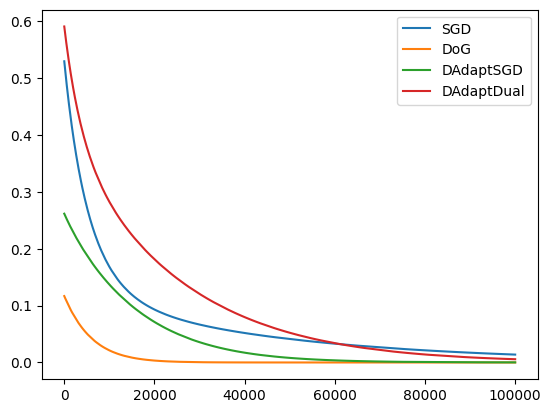

In [19]:
iterations = 100001

optimizers = [[sgd_optimizer, sgd_model],
              [dog_optimizer, dog_model],
              [dadapt_sgd_optimizer, dadapt_sgd_model],
              [dadapt_dual_optimizer, dadapt_dual_model]]
for (optimizer, model) in optimizers:
    quadratic_model_runner(optimizer, model, P, q, qs.optimal_point(), max_iter=iterations, log_per_iteration=1000)

plt.legend()
plt.show()

In [20]:
print(f"Actual optimal point: \t{qs.optimal_value()}")
print(f"DoG optimal point: \t{dog_model.optimal_value()}")
print(f"SGD optimal point: \t{sgd_model.optimal_value()}")
print(f"D-Adapt optimal point: \t{dadapt_sgd_model.optimal_value()}")

Actual optimal point: 	-0.769516521637732
DoG optimal point: 	-0.769522488117218
SGD optimal point: 	-0.7556535005569458
D-Adapt optimal point: 	-0.7693583369255066


SGD Method


  0%|          | 0/10001 [00:00<?, ?it/s]

Iter: 10000, 	Point Distance (d_i) from Optimal: 2.852841, 	Value Distance from Optimal: 	0.565499

DoG Method


  0%|          | 0/10001 [00:00<?, ?it/s]

Iter: 10000, 	Point Distance (d_i) from Optimal: 1.467940, 	Value Distance from Optimal: 	0.053279

DAdaptSGD Method


  0%|          | 0/10001 [00:00<?, ?it/s]

Iter: 10000, 	Point Distance (d_i) from Optimal: 2.680962, 	Value Distance from Optimal: 	0.195292

DAdaptDual Method


  0%|          | 0/10001 [00:00<?, ?it/s]

Iter: 10000, 	Point Distance (d_i) from Optimal: 0.280312, 	Value Distance from Optimal: 	0.001649



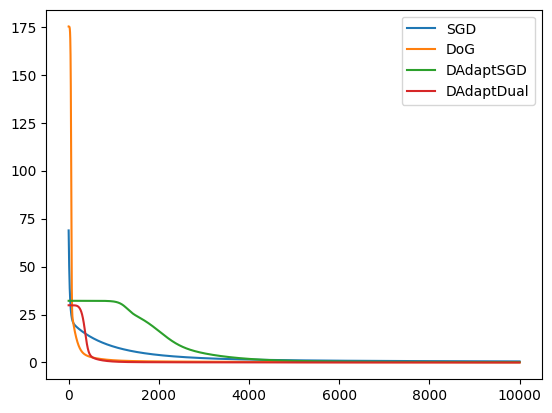

In [30]:
iterations = 10001

optimizers = [[sgd_optimizer, sgd_model],
              [dog_optimizer, dog_model],
              [dadapt_sgd_optimizer, dadapt_sgd_model],
              [dadapt_dual_optimizer, dadapt_dual_model]]
for (optimizer, model) in optimizers:
    quadratic_model_runner(optimizer, model, P, q, qs.optimal_point(), max_iter=iterations, log_per_iteration=1000, is_noisy=False)

plt.legend()
plt.show()